In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

df = pd.read_csv('clean_kaggle_data_2024.csv')

## Q1 - Exploratory Data Analysis

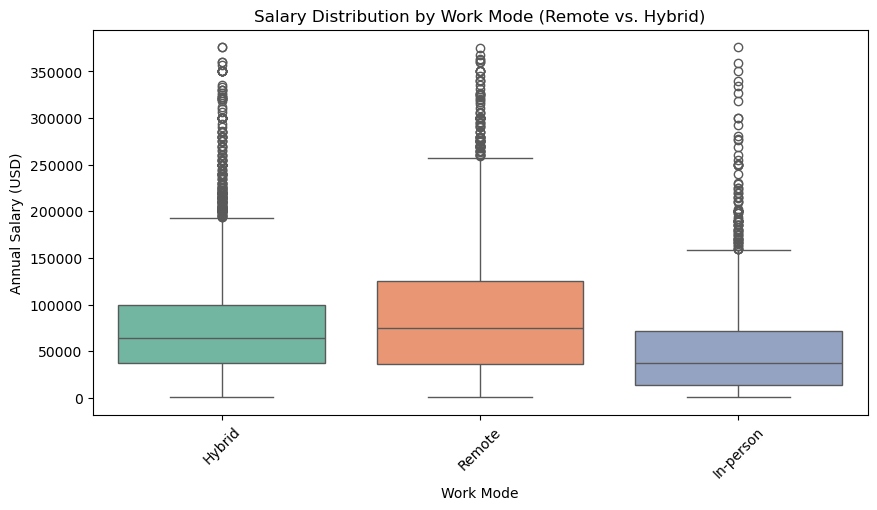

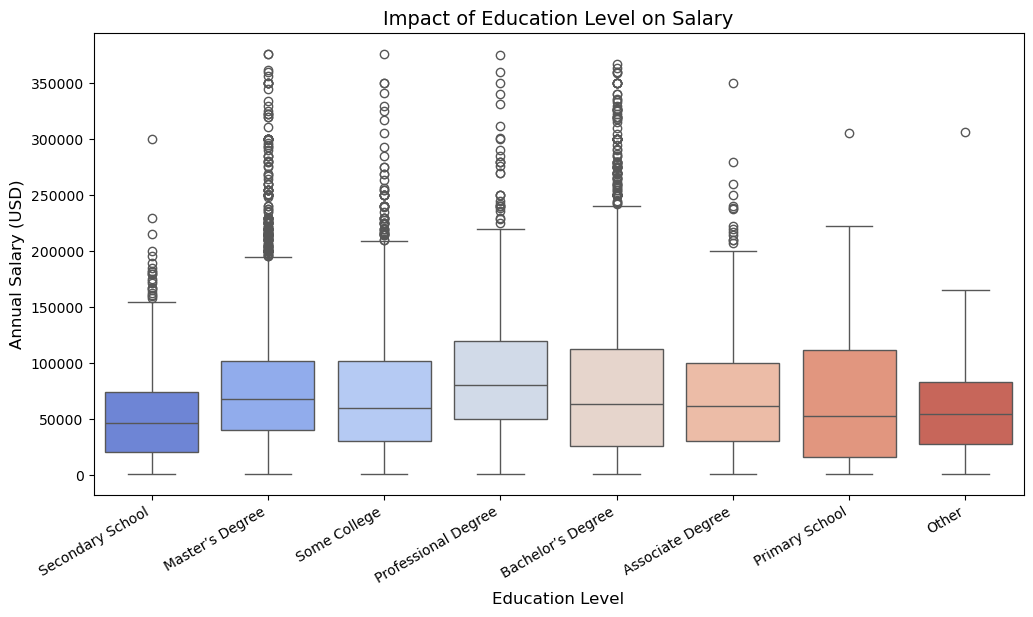

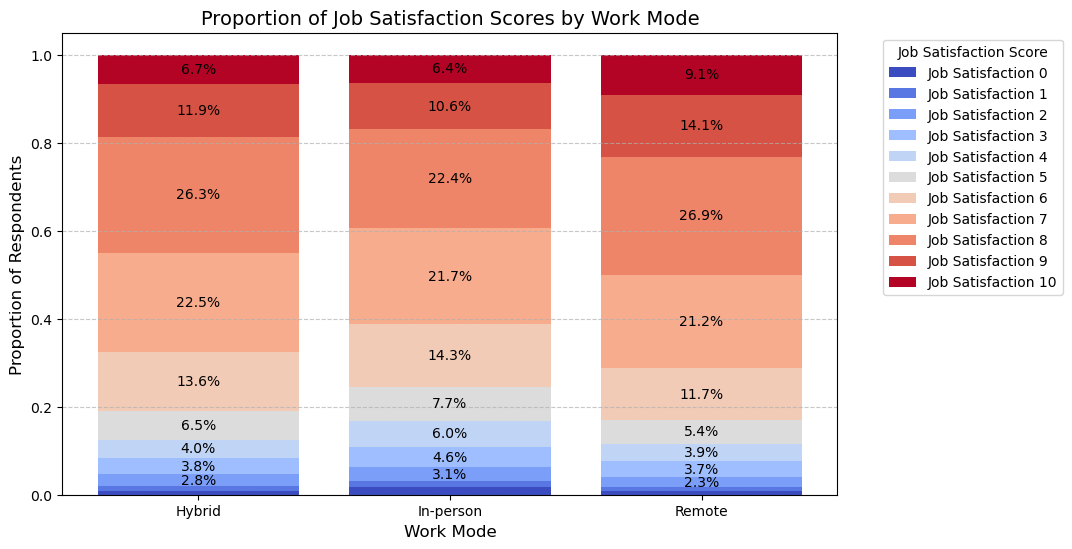

In [2]:
# Filter out extreme salary values for better visualization (removing top 1% outliers)
df_filtered = df[df["ConvertedCompYearly"].between(df["ConvertedCompYearly"].quantile(0.01), 
                                                   df["ConvertedCompYearly"].quantile(0.99))]

# Plot 1: Salary Distribution by Work Mode
plt.figure(figsize=(10, 5))
sns.boxplot(x="RemoteWork", y="ConvertedCompYearly", data=df_filtered, hue="RemoteWork", palette="Set2")
plt.title("Salary Distribution by Work Mode (Remote vs. Hybrid)")
plt.xlabel("Work Mode")
plt.ylabel("Annual Salary (USD)")
plt.xticks(rotation=45)
plt.show()

# Plot 2: Education Level vs. Salary
plt.figure(figsize=(12, 6))
sns.boxplot(x="EdLevel", y="ConvertedCompYearly", data=df_filtered, hue="EdLevel", palette="coolwarm")
plt.xticks(rotation=30, ha="right", fontsize=10)
plt.xlabel("Education Level", fontsize=12)
plt.ylabel("Annual Salary (USD)", fontsize=12)
plt.title("Impact of Education Level on Salary", fontsize=14)

# Adjust text for better readability
plt.xticks(ticks=range(len(df["EdLevel"].unique())), labels=[
    "Secondary School", "Master’s Degree", "Some College", "Professional Degree",
    "Bachelor’s Degree", "Associate Degree", "Primary School", "Other"
])
plt.show()

# Plot 3: Proportion of Job Satisfaction Scores By Work Mode
# Normalize job satisfaction distribution so each work mode sums to 1
job_sat_distribution = df.pivot_table(index="JobSat", columns="RemoteWork", aggfunc="size", fill_value=0)
job_sat_distribution = job_sat_distribution.div(job_sat_distribution.sum(axis=0), axis=1)

# Plot stacked bar chart with percentage labels
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.coolwarm(np.linspace(0, 1, len(job_sat_distribution.index)))  # Color map

# Stacked bars
bottom = np.zeros(len(job_sat_distribution.columns))  # Initialize bottom for stacking

for idx, job_sat_level in enumerate(job_sat_distribution.index):
    bars = ax.bar(job_sat_distribution.columns, job_sat_distribution.loc[job_sat_level], 
                  bottom=bottom, label=f"Job Satisfaction {job_sat_level}", color=colors[idx])
    
    # Add percentage labels
    for bar, value in zip(bars, job_sat_distribution.loc[job_sat_level]):
        if value > 0.02:  # Only show labels for non-tiny percentages
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2,
                    f"{value*100:.1f}%", ha="center", va="center", fontsize=10, color="black")

    bottom += job_sat_distribution.loc[job_sat_level]  # Update bottom for stacking

# Labels and formatting
ax.set_title("Proportion of Job Satisfaction Scores by Work Mode", fontsize=14)
ax.set_xlabel("Work Mode", fontsize=12)
ax.set_ylabel("Proportion of Respondents", fontsize=12)
ax.legend(title="Job Satisfaction Score", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=0)
plt.show()

## Q2 - Estimating Salary Diff between hybrid and remote job modes


### Q2a - Descriptive Statistics for Hybrid vs. Remote Salaries

In [ ]:
# Filter dataset for Hybrid and Remote workers
df_filtered = df[df["RemoteWork"].isin(["Hybrid", "Remote"])].copy()

# Remove missing salary values
df_filtered = df_filtered.dropna(subset=["ConvertedCompYearly"])

# Compute descriptive statistics for each work mode
desc_stats = df_filtered.groupby("RemoteWork")["ConvertedCompYearly"].describe().T.round(2)

print("Descriptive Statistics for Hybrid and Remote Workers:\n")
print(desc_stats)

Descriptive Statistics for Hybrid and Remote Workers:

RemoteWork       Hybrid      Remote
count           5272.00     4989.00
mean           84515.64    93850.62
std           241457.59   130228.13
min              109.00      104.00
25%            37081.75    36000.00
50%            64444.00    74595.00
75%           101910.00   127388.00
max         13818022.00  6340564.00


### Q2b - Two-Sample t-Test: Hybrid vs. Remote (Manual and Built-In)

In [ ]:
# Extract original Hybrid and Remote salary groups
hybrid_salaries = df[df["RemoteWork"] == "Hybrid"]["ConvertedCompYearly"].dropna()
remote_salaries = df[df["RemoteWork"] == "Remote"]["ConvertedCompYearly"].dropna()

# Manual computation of two-sample t-test
n_hybrid, n_remote = len(hybrid_salaries), len(remote_salaries)
mean_hybrid, mean_remote = np.mean(hybrid_salaries), np.mean(remote_salaries)
var_hybrid, var_remote = np.var(hybrid_salaries, ddof=1), np.var(remote_salaries, ddof=1)

# Compute pooled standard deviation
pooled_std = np.sqrt(((n_hybrid - 1) * var_hybrid + (n_remote - 1) * var_remote) / (n_hybrid + n_remote - 2))

# Compute t-statistic manually
t_stat_manual = (mean_hybrid - mean_remote) / (pooled_std * np.sqrt(1/n_hybrid + 1/n_remote))

# Compute degrees of freedom
df_degrees = n_hybrid + n_remote - 2

# Compute p-value manually (two-tailed test)
p_value_manual = 2 * (1 - stats.t.cdf(abs(t_stat_manual), df=df_degrees))

# Perform built-in t-test
t_stat_scipy, p_value_scipy = stats.ttest_ind(hybrid_salaries, remote_salaries, equal_var=True)

t_test_results = pd.DataFrame({
    "Method": ["Manual Calculation", "SciPy Built-in Function"],
    "T-Statistic": [t_stat_manual, t_stat_scipy],
    "P-Value": [p_value_manual, p_value_scipy]
})

t_test_results

,Method,T-Statistic,P-Value
0,Manual Calculation,-2.418113,0.015619
1,SciPy Built-in Function,-2.418113,0.015619


### Q2c - Bootstrapping Mean Salaries: Hybrid vs. Remote

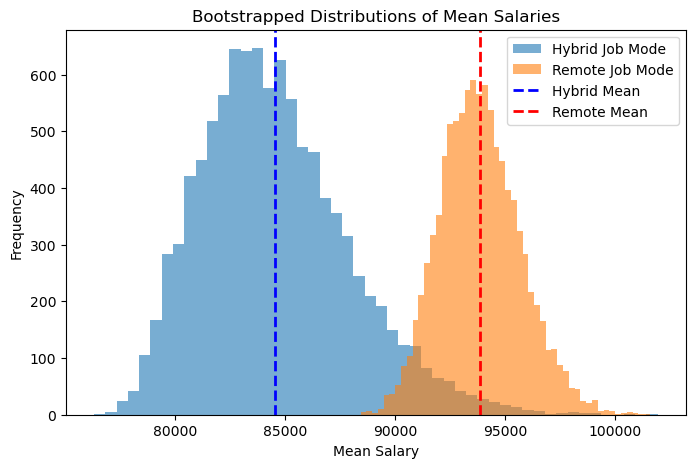

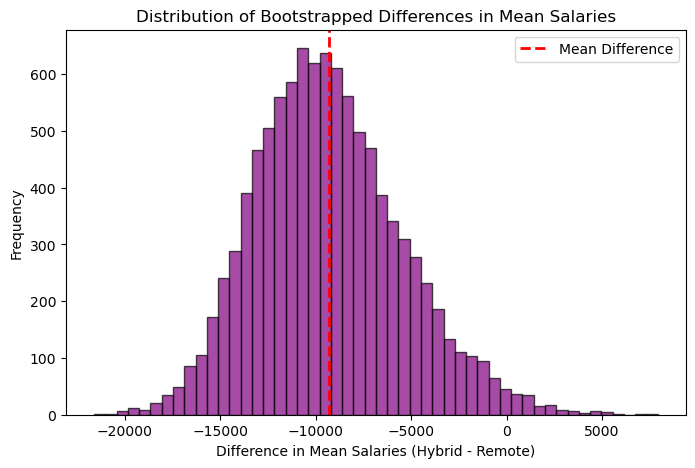

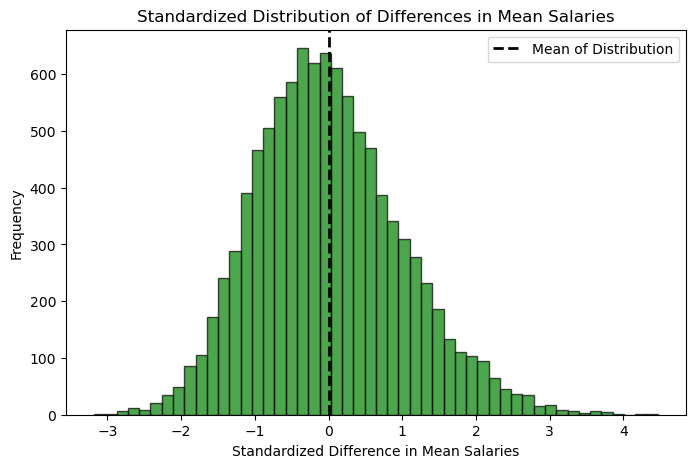

In [7]:
# Set number of bootstrap replications
n_bootstrap = 10000

# Bootstrap resampling
bootstrap_means_hybrid = [np.mean(np.random.choice(hybrid_salaries, size=len(hybrid_salaries), replace=True)) for _ in range(n_bootstrap)]
bootstrap_means_remote = [np.mean(np.random.choice(remote_salaries, size=len(remote_salaries), replace=True)) for _ in range(n_bootstrap)]

# Compute differences in means
bootstrap_diff_means = np.array(bootstrap_means_hybrid) - np.array(bootstrap_means_remote)

# Standardized distribution of the difference in means
bootstrap_diff_means_std = (bootstrap_diff_means - np.mean(bootstrap_diff_means)) / np.std(bootstrap_diff_means)

# Plot 1: Bootstrapped distributions of means
plt.figure(figsize=(8,5))
plt.hist(bootstrap_means_hybrid, bins=50, alpha=0.6, label='Hybrid Job Mode')
plt.hist(bootstrap_means_remote, bins=50, alpha=0.6, label='Remote Job Mode')
plt.axvline(np.mean(hybrid_salaries), color='blue', linestyle='dashed', linewidth=2, label='Hybrid Mean')
plt.axvline(np.mean(remote_salaries), color='red', linestyle='dashed', linewidth=2, label='Remote Mean')
plt.legend()
plt.title('Bootstrapped Distributions of Mean Salaries')
plt.xlabel('Mean Salary')
plt.ylabel('Frequency')
plt.show()

# Plot 2: Distribution of the difference in means
plt.figure(figsize=(8,5))
plt.hist(bootstrap_diff_means, bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.axvline(np.mean(bootstrap_diff_means), color='red', linestyle='dashed', linewidth=2, label='Mean Difference')
plt.legend()
plt.title('Distribution of Bootstrapped Differences in Mean Salaries')
plt.xlabel('Difference in Mean Salaries (Hybrid - Remote)')
plt.ylabel('Frequency')
plt.show()

# Plot 3: Standardized distribution of the difference in means
plt.figure(figsize=(8,5))
plt.hist(bootstrap_diff_means_std, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.axvline(np.mean(bootstrap_diff_means_std), color='black', linestyle='dashed', linewidth=2, label='Mean of Distribution')
plt.legend()
plt.title('Standardized Distribution of Differences in Mean Salaries')
plt.xlabel('Standardized Difference in Mean Salaries')
plt.ylabel('Frequency')
plt.show()


### Q2d - Two-sample t-test on bootstrapped data

In [7]:
# Performing a t-test using bootstrapped means
t_stat_bootstrap, p_value_bootstrap = stats.ttest_ind(bootstrap_means_hybrid, bootstrap_means_remote, equal_var=True)

# Comparing with the results from 2b
comparison_results = pd.DataFrame({
    "Method": ["Original t-test", "Bootstrapped t-test"],
    "T-Statistic": [t_stat_manual, t_stat_bootstrap],
    "P-Value": [p_value_manual, p_value_bootstrap]
})

comparison_results

,Method,T-Statistic,P-Value
0,Original t-test,-2.418113,0.015619
1,Bootstrapped t-test,-245.479596,0.000000


### Q2e - 95% Confidence Intervals: Formula vs. Bootstrap Methods

In [ ]:
# 95% Confidence Interval using the Formula-Based Approach (t-distribution method)
confidence_level = 0.95
alpha = 1 - confidence_level

# Standard error of the difference in means
se_diff = pooled_std * ((1/n_hybrid) + (1/n_remote)) ** 0.5

# Critical t-value for 95% CI
t_critical = stats.t.ppf(1 - alpha/2, df=df_degrees)

# Confidence Interval
ci_lower_formula = (mean_hybrid - mean_remote) - t_critical * se_diff
ci_upper_formula = (mean_hybrid - mean_remote) + t_critical * se_diff

# 95% Confidence Interval using Bootstrapping
ci_lower_bootstrap = np.percentile(bootstrap_diff_means, 2.5)
ci_upper_bootstrap = np.percentile(bootstrap_diff_means, 97.5)

ci_comparison = pd.DataFrame({
    "Method": ["Formula-Based CI", "Bootstrap-Based CI"],
    "Lower Bound": [ci_lower_formula, ci_lower_bootstrap],
    "Upper Bound": [ci_upper_formula, ci_upper_bootstrap]
})

ci_comparison

,Method,Lower Bound,Upper Bound
0,Formula-Based CI,-16902.185722,-1767.761330
1,Bootstrap-Based CI,-16056.044278,-1089.805314


### Q2f - Median Salary Comparison: Mood’s Test vs. Bootstrap

In [ ]:
# Performing Mood's Median Test (Nonparametric Test)
mood_stat, mood_p_value, _, _ = stats.median_test(hybrid_salaries, remote_salaries)

# Bootstrapping medians
bootstrap_medians_hybrid = [np.median(np.random.choice(hybrid_salaries, size=len(hybrid_salaries), replace=True)) for _ in range(n_bootstrap)]
bootstrap_medians_remote = [np.median(np.random.choice(remote_salaries, size=len(remote_salaries), replace=True)) for _ in range(n_bootstrap)]

# Bootstrapped differences in medians
bootstrap_diff_medians = np.array(bootstrap_medians_hybrid) - np.array(bootstrap_medians_remote)

# Computing two-sided p-value from bootstrapped medians
p_value_bootstrap_medians = 2 * min(
    np.mean(bootstrap_diff_medians >= 0),
    np.mean(bootstrap_diff_medians <= 0)
)

median_comparison = pd.DataFrame({
    "Method": ["Mood's Median Test", "Bootstrap Median Test"],
    "Statistic": [mood_stat, None],
    "P-Value": [mood_p_value, p_value_bootstrap_medians]
})

median_comparison


,Method,Statistic,P-Value
0,Mood's Median Test,50.13554,1.434846e-12
1,Bootstrap Median Test,NaN,0.000000e+00


## Q3 - Effect of Education on Income in North America (ANOVA)

### Q3a - Descriptive Statistics by Education Level

In [ ]:
# Re-filtering the dataset for only North American participants with selected education levels
education_levels = ["Bachelor’s degree", "Master’s degree", "Professional degree"]
df_filtered_edu = df[(df['Country'].isin(['United States', 'Canada'])) & 
                     (df['EdLevel'].isin(education_levels))][['EdLevel', 'ConvertedCompYearly']].dropna()

# Computing descriptive statistics for each education level
ed_stats = df_filtered_edu.groupby("EdLevel")["ConvertedCompYearly"].describe().T.round(2)

print("Descriptive Statistics by Education Level:\n")
print(ed_stats)

Descriptive Statistics by Education Level:

EdLevel  Bachelor’s degree  Master’s degree  Professional degree
count               204.00            90.00                17.00
mean             116842.97        109309.84            125623.00
std              138969.35         50108.29             72956.26
min                 153.00         18000.00             50885.00
25%               66877.00         75782.75             72693.00
50%               90866.00        101770.00             87231.00
75%              126667.75        130847.00            166467.00
max             1500000.00        319849.00            290772.00


### Q3b - One-Way ANOVA on Salaries Across Education Levels

In [ ]:
# Extracting salary data for each education level
bachelor_salaries = df_filtered_edu[df_filtered_edu['EdLevel'] == "Bachelor’s degree"]['ConvertedCompYearly']
master_salaries = df_filtered_edu[df_filtered_edu['EdLevel'] == "Master’s degree"]['ConvertedCompYearly']
professional_salaries = df_filtered_edu[df_filtered_edu['EdLevel'] == "Professional degree"]['ConvertedCompYearly']

# Performing ANOVA test
anova_stat, anova_p_value = stats.f_oneway(bachelor_salaries, master_salaries, professional_salaries)

anova_results = {
    "ANOVA Statistic": anova_stat,
    "p-value": anova_p_value 
}

anova_results

{'ANOVA Statistic': 0.20097169298358647, 'p-value': 0.8180427584299953}

### Q3c - Bootstrapping Mean Salaries by Education Level

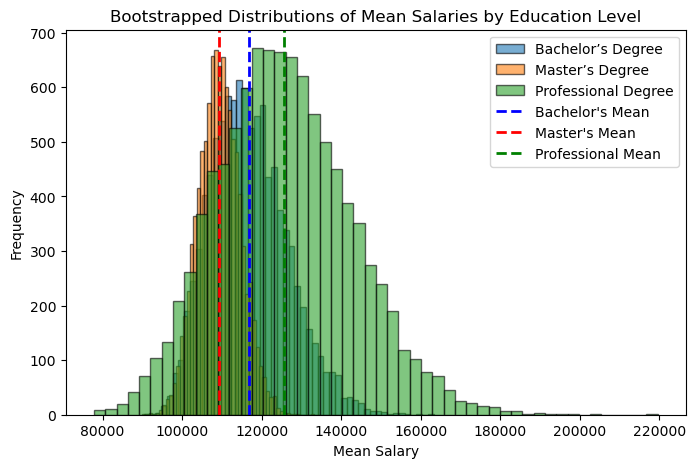

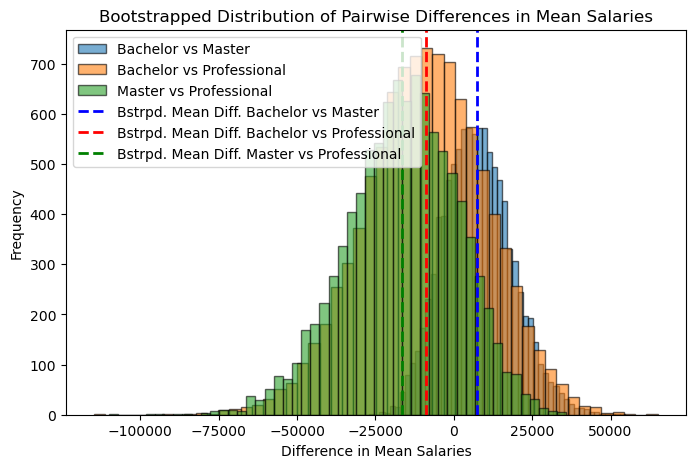

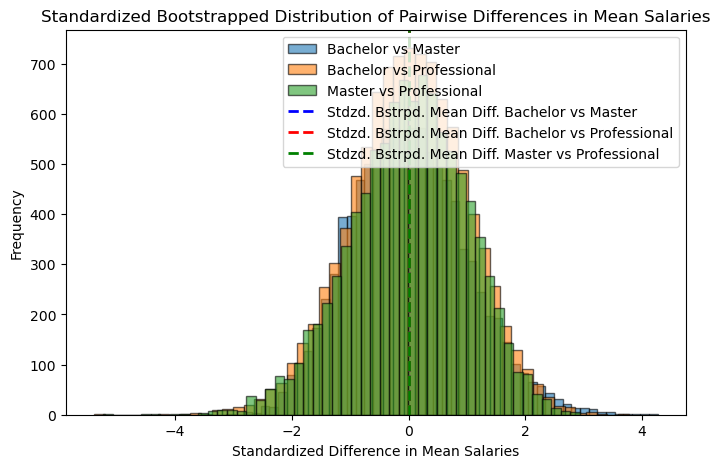

In [ ]:
# Number of bootstrap replications
n_bootstrap = 10000

# Bootstrap resampling for mean salaries of each education level
bootstrap_means_bachelor = [np.mean(np.random.choice(bachelor_salaries, size=len(bachelor_salaries), replace=True)) for _ in range(n_bootstrap)]
bootstrap_means_master = [np.mean(np.random.choice(master_salaries, size=len(master_salaries), replace=True)) for _ in range(n_bootstrap)]
bootstrap_means_professional = [np.mean(np.random.choice(professional_salaries, size=len(professional_salaries), replace=True)) for _ in range(n_bootstrap)]

# Compute bootstrapped differences in means for pairwise comparisons
bootstrap_diff_bachelor_master = np.array(bootstrap_means_bachelor) - np.array(bootstrap_means_master)
bootstrap_diff_bachelor_professional = np.array(bootstrap_means_bachelor) - np.array(bootstrap_means_professional)
bootstrap_diff_master_professional = np.array(bootstrap_means_master) - np.array(bootstrap_means_professional)

# Standardized distributions of the difference in means
bootstrap_diff_bachelor_master_std = (bootstrap_diff_bachelor_master - np.mean(bootstrap_diff_bachelor_master)) / np.std(bootstrap_diff_bachelor_master)
bootstrap_diff_bachelor_professional_std = (bootstrap_diff_bachelor_professional - np.mean(bootstrap_diff_bachelor_professional)) / np.std(bootstrap_diff_bachelor_professional)
bootstrap_diff_master_professional_std = (bootstrap_diff_master_professional - np.mean(bootstrap_diff_master_professional)) / np.std(bootstrap_diff_master_professional)

# Plot 1: Bootstrapped distributions of mean salaries for each education level
plt.figure(figsize=(8,5))
plt.hist(bootstrap_means_bachelor, bins=50, alpha=0.6, label="Bachelor’s Degree", edgecolor='black')
plt.hist(bootstrap_means_master, bins=50, alpha=0.6, label="Master’s Degree", edgecolor='black')
plt.hist(bootstrap_means_professional, bins=50, alpha=0.6, label="Professional Degree", edgecolor='black')
plt.axvline(np.mean(bachelor_salaries), color='blue', linestyle='dashed', linewidth=2, label="Bachelor's Mean")
plt.axvline(np.mean(master_salaries), color='red', linestyle='dashed', linewidth=2, label="Master's Mean")
plt.axvline(np.mean(professional_salaries), color='green', linestyle='dashed', linewidth=2, label="Professional Mean")
plt.legend()
plt.title('Bootstrapped Distributions of Mean Salaries by Education Level')
plt.xlabel('Mean Salary')
plt.ylabel('Frequency')
plt.show()

# Plot 2: Distribution of the pairwise differences in means
plt.figure(figsize=(8,5))
plt.hist(bootstrap_diff_bachelor_master, bins=50, alpha=0.6, label="Bachelor vs Master", edgecolor='black')
plt.hist(bootstrap_diff_bachelor_professional, bins=50, alpha=0.6, label="Bachelor vs Professional", edgecolor='black')
plt.hist(bootstrap_diff_master_professional, bins=50, alpha=0.6, label="Master vs Professional", edgecolor='black')
plt.axvline(np.mean(bootstrap_diff_bachelor_master), color='blue', linestyle='dashed', linewidth=2, label="Bstrpd. Mean Diff. Bachelor vs Master")
plt.axvline(np.mean(bootstrap_diff_bachelor_professional), color='red', linestyle='dashed', linewidth=2, label="Bstrpd. Mean Diff. Bachelor vs Professional")
plt.axvline(np.mean(bootstrap_diff_master_professional), color='green', linestyle='dashed', linewidth=2, label="Bstrpd. Mean Diff. Master vs Professional")
plt.legend()
plt.title('Bootstrapped Distribution of Pairwise Differences in Mean Salaries')
plt.xlabel('Difference in Mean Salaries')
plt.ylabel('Frequency')
plt.show()

# Plot 3: Standardized distribution of the differences in means
plt.figure(figsize=(8,5))
plt.hist(bootstrap_diff_bachelor_master_std, bins=50, alpha=0.6, label="Bachelor vs Master", edgecolor='black')
plt.hist(bootstrap_diff_bachelor_professional_std, bins=50, alpha=0.6, label="Bachelor vs Professional", edgecolor='black')
plt.hist(bootstrap_diff_master_professional_std, bins=50, alpha=0.6, label="Master vs Professional", edgecolor='black')
plt.axvline(np.mean(bootstrap_diff_bachelor_master_std), color='blue', linestyle='dashed', linewidth=2, label="Stdzd. Bstrpd. Mean Diff. Bachelor vs Master")
plt.axvline(np.mean(bootstrap_diff_bachelor_professional_std), color='red', linestyle='dashed', linewidth=2, label="Stdzd. Bstrpd. Mean Diff. Bachelor vs Professional")
plt.axvline(np.mean(bootstrap_diff_master_professional_std), color='green', linestyle='dashed', linewidth=2, label="Stdzd. Bstrpd. Mean Diff. Master vs Professional")
plt.legend()
plt.title('Standardized Bootstrapped Distribution of Pairwise Differences in Mean Salaries')
plt.xlabel('Standardized Difference in Mean Salaries')
plt.ylabel('Frequency')
plt.show()


In [12]:
np.mean(bootstrap_diff_bachelor_master_std),np.mean(bootstrap_diff_bachelor_professional_std),np.mean(bootstrap_diff_master_professional_std)

(-5.1514348342607266e-17, 6.73239242132695e-17, -8.943956686380261e-17)

### Q3d - Post-Hoc Comparison and Resolving ANOVA Contradiction

In [ ]:
# Performing ANOVA on bootstrapped means again for verification
anova_stat_bootstrap, anova_p_value_bootstrap = stats.f_oneway(
    bootstrap_means_bachelor, bootstrap_means_master, bootstrap_means_professional
)

# Display results
anova_bootstrap_results = {
    "Bootstrapped ANOVA Statistic": anova_stat_bootstrap,
    "Bootstrapped p-value": anova_p_value_bootstrap
}

# Checking if post-hoc tests are needed (only if p-value < 0.05)
perform_post_hoc = anova_p_value_bootstrap < 0.05

anova_bootstrap_results, perform_post_hoc

({'Bootstrapped ANOVA Statistic': 4770.81209572015,
  'Bootstrapped p-value': 0.0},
 True)

In [ ]:
# 3d continued
# Tukey's HSD post-hoc analysis
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Creating data for Tukey's HSD test using bootstrapped means
education_labels = (["Bachelor’s Degree"] * n_bootstrap +
                    ["Master’s Degree"] * n_bootstrap +
                    ["Professional Degree"] * n_bootstrap)

bootstrapped_salaries = np.concatenate([bootstrap_means_bachelor, bootstrap_means_master, bootstrap_means_professional])

# Performing Tukey's HSD test
tukey_test = pairwise_tukeyhsd(bootstrapped_salaries, education_labels, alpha=0.05)

# Display Tukey's HSD results
tukey_test.summary()


# Convert Tukey's HSD results into a structured DataFrame
tukey_results_df = pd.DataFrame(
    data=tukey_test._results_table.data[1:],  
    columns=tukey_test._results_table.data[0] 
)

# Display Tukey's HSD results
print(tukey_results_df)

              group1               group2    meandiff  p-adj       lower  \
0  Bachelor’s Degree      Master’s Degree  -7595.4842    0.0  -7985.9254   
1  Bachelor’s Degree  Professional Degree   8664.8750    0.0   8274.4339   
2    Master’s Degree  Professional Degree  16260.3593    0.0  15869.9182   

        upper  reject  
0  -7205.0431    True  
1   9055.3162    True  
2  16650.8004    True  
